* this part is about data cleaning for task 1 

* listing_id - unique identifier of the property listing
    * drop
* title - title of the property listing (e.g., "2 bed condo for sale in 35 gilstead")
    * drop
* address - address of the property (e.g., "124 punggol walk", "11 sengkang east avenue")
    * drop
* property_name - name of the property (e.g., "redhill rise", "klimt cairnhill")
    * provide information, but drop at the end; average price
* property_type - type of the property (e.g., "condo", "hdb 2 rooms", "landed")
    * aggregation, hdb 2/3/4 rooms -> hdb
* Z'tenure' - tenure of the property (e.g., "freehold", "99-year leasehold")
    * 1.aggregation, 99/999/freehold, /2.or convert to numeric, left tenure years; assign tenure values of each property type to na value; tenure may affect price, for example, decreases largely last 40 years
* Z'built_year' - year when the property was was built (e.g., 2014, 2021)
    * to numeric;make built_year interval data and replenish na values with same processing of tenure
* O'num_beds' - number of bedrooms (e.g., 1, 2, 3)
    * na -> 0
* O'num_baths' - number of bathrooms (e.g., 1, 2, 3)
    * na: assign values according to property_name and sqft; or according to num_beds
* S'size_sqft' - floor area in square feet (e.g., 807, 657, 1628)
    * box plot visualization for outlier points processing, large -> /1000, small -> *100 or 0 for deletion; sqft price for data assigning according to grouping by attribute
* floor_level - information about the floor level of the property (e.g., "high", "low")
    * drop
* furnishing - information whether the property is furnished (e.g., "fully", "partial")
    * drop(70% unspecified) or one-hot as category type
* available_unit_types - list of all types of units available in the property complex (e.g., "studio, 3, 4, 5 br")
    * maybe drop
* total_num_units - total number of units in the property complex (e.g., 115, 200)
    * maybe drop
* property_details_url - URL linking to more information about the property complex
    * maybe drop or provide information
* J'lat' - latitude of property (e.g., 1.328805)
* J'lng' - longitude of property (e.g., 103.74502)
    * lat & lng for aulixiary data calculation; assign value to extreme lat & lng according to property_name
* elevation - elevation of the property in meters (e.g., 10)
    * drop
* J'subszone' - subzone of block containing the flat in meter (e.g., "blangah rise", "marymount")
    * keep one, or planning area; knn to assign subzone to na
* planning_area - planning area of block containing the flat (e.g., "woodlands", "bukit merah")
    * keep one, or subzone
* S'price' - sales price in SGD
    * outliers processing
    
    
model:
kernel ridge,
xgboost,
random forest(regression/ classification)


借助99.co所有成交价格上下限，做decision tree分类问题

新加坡地产管理：经纬度可以返回具体的planning area

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
data_train = pd.read_csv('./data/train.csv')

## Preprocess size_sqft attribute

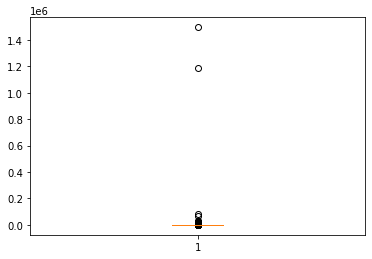

In [3]:
plt.boxplot(data_train['size_sqft'])

plt.show()

In [4]:
data_train[data_train['size_sqft']>1e6]

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
2701,160293,3 bed condo for sale in jlb residences,169 jalan loyang besar,jlb residences,condo,946-year leasehold,2008.0,3.0,2.0,1185000,...,unfurnished,3 br,36.0,https://www.99.co/singapore/condos-apartments/...,1.379105,103.960613,0,pasir ris park,pasir ris,1244200.0
18446,771950,4 bed condo for sale in avenue south residence,1 silat avenue,avenue south residence,condo,99-year leasehold,2023.0,4.0,4.0,1496000,...,unspecified,"studio, 1, 2, 3, 4 br",1074.0,https://www.99.co/singapore/condos-apartments/...,1.304855,103.773776,0,dover,queenstown,3040800.0


* According to box plot, there are two outlier points with size_sqft bigger than 1e6 and according to size_sqft value of other similar condos, size_sqft value should be less than 1e4. For these two points, we divide them by 1000.
* 

In [5]:
data_train["size_sqft"] = np.where(data_train["size_sqft"] > 1e6, data_train["size_sqft"]/1000, data_train["size_sqft"])


In [6]:
data_train[data_train['size_sqft']>1e6]

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price


* After processing two extreme outliers, we show box plot again and find that there is still some extreme values and here, we selected data records with size_sqft larger than 20000. With showing description under each property, it can be concluded that two points with size_sqft larger than 60000 are outliers as other points with same property_name have smaller sqft range. If we divide sqft in these two points by 10, we can find that data description grouped by these two property_name are more normal.

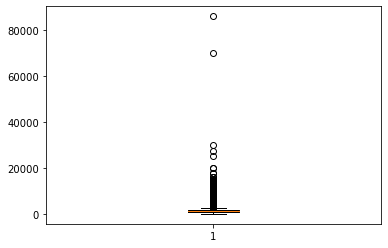

In [7]:
plt.boxplot(data_train['size_sqft'])

plt.show()

In [8]:
data_train[data_train['size_sqft']>20000]

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
1649,149017,10 bed house for sale in braddell heights estate,cotswold close,braddell heights estate,bungalow,freehold,2011.0,10.0,10.0,30000.0,...,unspecified,"3, 4, 5, 6, 7, 8, 10 br",NaN,https://www.99.co/singapore/houses/braddell-he...,1.346020,103.867198,0,lorong chuan,serangoon,29400000.0
4287,753969,6 bed house for sale in bedok park,limau garden,bedok park,semi-detached house,freehold,1970.0,6.0,7.0,86080.0,...,unspecified,"5, 6, 10 br",NaN,https://www.99.co/singapore/houses/bedok-park-...,1.306408,103.932790,0,siglap,bedok,6279000.0
13461,571444,6 bed house for sale in westville,westwood terrace,westville,terraced house,99-year leasehold,1997.0,6.0,5.0,25003.0,...,unspecified,"2, 4, 5, 6 br",339.0,https://www.99.co/singapore/houses/westville-d...,1.352481,103.699082,0,yunnan,jurong west,2625000.0
13589,476002,8 bed house for sale in ladyhill park,fernhill road,ladyhill park,bungalow,freehold,1990.0,8.0,9.0,27500.0,...,unspecified,"3, 5, 6, 8 br",17.0,https://www.99.co/singapore/houses/ladyhill-pa...,1.311925,103.824001,0,nassim,tanglin,58800000.0
15637,522703,6 bed house for sale in swiss club park,jalan senandong,swiss club park,Bungalow,freehold,1997.0,6.0,6.0,70000.0,...,unspecified,"4, 5, 6, 7 br",NaN,https://www.99.co/singapore/houses/swiss-club-...,1.335877,103.789611,0,swiss club,bukit timah,40950000.0


In [9]:
property_name = data_train[data_train['size_sqft']>20000]['property_name']
property_name

1649     braddell heights estate
4287                  bedok park
13461                  westville
13589              ladyhill park
15637            swiss club park
Name: property_name, dtype: object

In [10]:
for i in property_name:
    print(i, data_train[(data_train['size_sqft']>20000) & (data_train['property_name'] == i)]['size_sqft'])
    print(data_train[data_train['property_name']==i]['size_sqft'].describe())

braddell heights estate 1649    30000.0
Name: size_sqft, dtype: float64
count       22.000000
mean      7827.181818
std       5676.490152
min       4500.000000
25%       5398.500000
50%       6150.000000
75%       7700.000000
max      30000.000000
Name: size_sqft, dtype: float64
bedok park 4287    86080.0
Name: size_sqft, dtype: float64
count       16.000000
mean     11978.250000
std      19854.422354
min       3200.000000
25%       7210.250000
50%       8000.000000
75%       8012.000000
max      86080.000000
Name: size_sqft, dtype: float64
westville 13461    25003.0
Name: size_sqft, dtype: float64
count        6.000000
mean      6309.166667
std       9164.470621
min       2152.000000
25%       2500.000000
50%       2500.000000
75%       3025.000000
max      25003.000000
Name: size_sqft, dtype: float64
ladyhill park 13589    27500.0
Name: size_sqft, dtype: float64
count        5.000000
mean     12300.000000
std      10929.318368
min       2000.000000
25%       5000.000000
50%       700

In [11]:
data_train["size_sqft"] = np.where(data_train["size_sqft"] > 60000, data_train["size_sqft"]/10, data_train["size_sqft"])


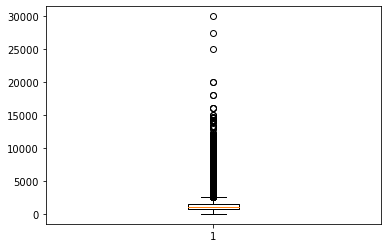

In [12]:
plt.boxplot(data_train['size_sqft'])

plt.show()

* Again, from box plot, min size_sqft is 0 and after viewing all data points with property_name of 'clavon' and size_sqft of 5, we find that every point has same size_sqft value 1690, so we assign 1690 to this 0 point.

In [13]:
data_train[data_train['size_sqft']==0]

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
5682,145832,5 bed condo for sale in clavon,4 clementi avenue 1,clavon,condo,99-year leasehold,2025.0,5.0,4.0,0.0,...,unspecified,"1, 2, 3, 4, 5 br",640.0,https://www.99.co/singapore/condos-apartments/...,1.308012,103.767318,0,clementi woods,clementi,0.0


In [14]:
data_train[(data_train['property_name']=='clavon') & (data_train['num_beds']==5)]

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
182,563836,5 bed condo for sale in clavon,4 clementi avenue 1,clavon,condo,99-year leasehold,2025.0,5.0,4.0,1690.0,...,unspecified,"1, 2, 3, 4, 5 br",640.0,https://www.99.co/singapore/condos-apartments/...,1.308012,103.767318,0,clementi woods,clementi,3059700.0
5682,145832,5 bed condo for sale in clavon,4 clementi avenue 1,clavon,condo,99-year leasehold,2025.0,5.0,4.0,0.0,...,unspecified,"1, 2, 3, 4, 5 br",640.0,https://www.99.co/singapore/condos-apartments/...,1.308012,103.767318,0,clementi woods,clementi,0.0
10370,622377,5 bed condo for sale in clavon,4 clementi avenue 1,clavon,condo,99-year leasehold,2025.0,5.0,4.0,1690.0,...,unspecified,"1, 2, 3, 4, 5 br",640.0,https://www.99.co/singapore/condos-apartments/...,1.308012,103.767318,0,clementi woods,clementi,2857000.0
13558,643916,5 bed condo for sale in clavon,8 clementi avenue 1,clavon,condo,99-year leasehold,2025.0,5.0,3.0,1690.0,...,unspecified,"1, 2, 3, 4, 5 br",640.0,https://www.99.co/singapore/condos-apartments/...,1.308012,103.767318,0,clementi woods,clementi,3010400.0
17634,934263,5 bed condo for sale in clavon,6 clementi avenue 1,clavon,condo,99-year leasehold,2025.0,5.0,4.0,1690.0,...,unspecified,"1, 2, 3, 4, 5 br",640.0,https://www.99.co/singapore/condos-apartments/...,1.308012,103.767318,0,clementi woods,clementi,2922200.0
19463,228520,5 bed condo for sale in clavon,4 clementi avenue 1,clavon,condo,99-year leasehold,2025.0,5.0,4.0,1690.0,...,unspecified,"1, 2, 3, 4, 5 br",640.0,https://www.99.co/singapore/condos-apartments/...,1.308012,103.767318,0,clementi woods,clementi,2940000.0
19864,530313,5 bed condo for sale in clavon,4 clementi avenue 1,clavon,condo,99-year leasehold,2025.0,5.0,4.0,1690.0,...,unspecified,"1, 2, 3, 4, 5 br",640.0,https://www.99.co/singapore/condos-apartments/...,1.308012,103.767318,0,clementi woods,clementi,2788800.0


In [15]:
data_train["size_sqft"] = np.where(data_train["size_sqft"] == 0, 1690, data_train["size_sqft"])


* Then we turn to these extremely small size_sqft values, if size_sqft value is smaller than 1/10 of middle value of attribute description, we consider this point as outlier and multiply its size_sqft value by 10.

In [16]:
uni_property_name = data_train['property_name'].unique()
uni_property_name

array(['866 yishun street 81', 'hdb-serangoon estate', 'meyerhouse', ...,
       'signature park', 'raya garden', '241 yishun ring road'],
      dtype=object)

In [17]:
extre_list = []
for uni_name in uni_property_name:
    mid_dt = data_train[data_train['property_name']==uni_name]['size_sqft'].describe()['50%']    
    min_dt = data_train[data_train['property_name']==uni_name]['size_sqft'].describe()['min']
    if mid_dt >= min_dt * 10:
        extre_list += data_train[(data_train['size_sqft'] < mid_dt/10) & (data_train['property_name'] == uni_name)]['listing_id'].values.tolist()


In [18]:
for lst_id in extre_list:
    data_train["size_sqft"] = np.where(data_train["listing_id"] == lst_id, data_train["size_sqft"] * 10, data_train["size_sqft"])


## Preprocessing price attribute

* Now we turn to processing price attribute, as before, firstly we show its distribution and box plot to find possible outliers.

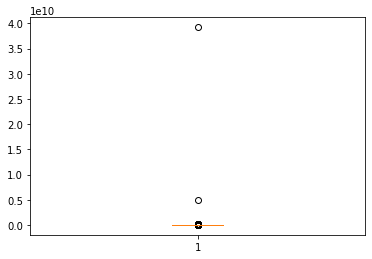

In [19]:
plt.boxplot(data_train['price'])
plt.show()


In [38]:
data_train[data_train['price']>1e8]

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price,price_sqft
635,432676,3 bed house for sale in the glencaird residences,dalvey road,the glencaird residences,Land Only,freehold,2000.0,3.0,3.0,1070.0,...,"3, 4, 5, 6 br",12.0,https://www.99.co/singapore/houses/the-glencai...,1.315477,103.819725,0,nassim,tanglin,1.016400e+08,9.499065e+04
5976,385586,hdb flat for sale in 238 compassvale walk,hougang / punggol / sengkang (d19),compassvale plains,hdb 4 rooms,99-year leasehold,1999.0,1.0,10.0,232.0,...,"1, 3, 4 br",NaN,https://www.99.co/singapore/hdb/compassvale-pl...,1.390556,103.898921,0,sengkang town centre,sengkang,3.924243e+10,1.691484e+08
6115,917822,5 bed house for sale in maplewoods,bukit timah road,maplewoods,bungalow,freehold,1997.0,5.0,5.0,7000.0,...,"2, 3, 4, 5 br",697.0,https://www.99.co/singapore/condos-apartments/...,1.334360,103.784785,0,holland road,bukit timah,1.155000e+08,1.650000e+04
6396,494501,3 bed house for sale in oei tiong ham park,tanglin / holland (d10),oei tiong ham park,bungalow,freehold,1997.0,3.0,2.0,5000.0,...,"3, 4, 5, 6, 8 br",NaN,https://www.99.co/singapore/houses/oei-tiong-h...,1.315580,103.792829,0,leedon park,bukit timah,1.050000e+08,2.100000e+04
16264,287109,hdb flat for sale in 238 compassvale walk,hougang / punggol / sengkang (d19),compassvale plains,hdb 4 rooms,99-year leasehold,1999.0,1.0,10.0,129.0,...,"1, 3, 4 br",NaN,https://www.99.co/singapore/hdb/compassvale-pl...,1.390556,103.898921,0,sengkang town centre,sengkang,4.985919e+09,3.865053e+07
19091,229401,10 bed house for sale in queen astrid park,queen astrid park,queen astrid park,Bungalow,999-year leasehold,1989.0,10.0,10.0,16000.0,...,"5, 6, 7, 8, 10 br",NaN,https://www.99.co/singapore/houses/queen-astri...,1.317659,103.790578,0,leedon park,bukit timah,1.144500e+08,7.153125e+03


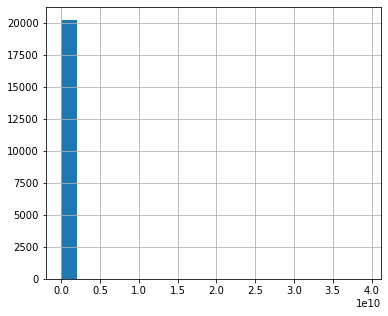

In [20]:
data_train['price'].hist(bins=20, figsize=(6,5))
plt.show()


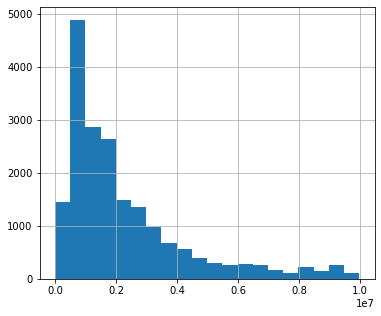

In [21]:
data_train[data_train['price']<1e7]['price'].hist(bins=20, figsize=(6,5))
plt.show()


/Users/mingyuesong/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


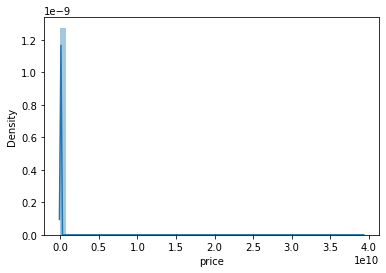

In [22]:
sns.distplot(data_train['price'])
plt.show()


* We would like to set a certain rule to recognize outliers, and in the following cells, we showed data records with 0 price and those with low price compared to other points in same property_name. 
    * With further observation, data points with 0 price are with built after 2021 and may not have sales record yet, here we drop these data points as they cannot provide useful price info.
    * Identifying outliers in price:
        * When we want to identify outliers with the same method as we do to 'size_sqft', with reference to info on 99.co, we find that extremely large prices are possible. Also, if sale prices are largely different in one property_name, it is also reasonable with different sales date and sqft.
        * Next we try to focus on extremely low prices. Two point are less than 1/10 of their middle price in same property_name and they seem normal compared with 25% value.

In [23]:
data_train[data_train['price']==0]


,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
49,478899,3 bed condo for sale in uptown @ farrer,2 perumal road,uptown @ farrer,condo,99-year leasehold,2021.0,3.0,3.0,1292.0,...,unspecified,"studio, 2, 3, 4, 5 br",116.0,https://www.99.co/singapore/condos-apartments/...,1.312994,103.855616,0,lavender,kallang,0.0
289,224728,5 bed condo for sale in normanton park,49 normanton park,normanton park,condo,99-year leasehold,2023.0,5.0,4.0,1798.0,...,unspecified,"studio, 1, 2, 3, 4, 5 br",1862.0,https://www.99.co/singapore/condos-apartments/...,1.287158,103.792138,0,kent ridge,queenstown,0.0
388,483663,2 bed condo for sale in royalgreen,2 anamalai avenue,royalgreen,condo,freehold,2021.0,2.0,2.0,861.0,...,unspecified,"2, 3, 4, 5 br",285.0,https://www.99.co/singapore/condos-apartments/...,1.330403,103.794939,0,holland road,bukit timah,0.0
413,927196,2 bed condo for sale in uptown @ farrer,2 perumal road,uptown @ farrer,condo,99-year leasehold,2021.0,2.0,2.0,538.0,...,unspecified,"studio, 2, 3, 4, 5 br",116.0,https://www.99.co/singapore/condos-apartments/...,1.312994,103.855616,0,lavender,kallang,0.0
467,663178,4 bed condo for sale in the woodleigh residenc...,19 bidadari park drive,the woodleigh residences / the woodleigh mall,condo,99-year leasehold,2024.0,4.0,NaN,1475.0,...,unspecified,"1, 2, 3, 4 br",667.0,https://www.99.co/singapore/condos-apartments/...,1.338693,103.871750,0,bidadari,toa payoh,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19003,322693,3 bed condo for sale in the antares,19 mattar road,the antares,condo,99-year leasehold,2022.0,3.0,2.0,1023.0,...,unspecified,"1, 2, 3, 4 br",265.0,https://www.99.co/singapore/condos-apartments/...,1.325521,103.883276,0,macpherson,geylang,0.0
19407,382008,3 bed condo for sale in midwood,8 hillview rise,midwood,condo,99-year leasehold,2024.0,3.0,3.0,990.0,...,unspecified,"1, 2, 3, 4 br",564.0,https://www.99.co/singapore/condos-apartments/...,1.363469,103.763730,0,hillview,bukit batok,0.0
19487,539717,3 bed condo for sale in one meyer,1 meyer place,one meyer,condo,freehold,2023.0,3.0,2.0,915.0,...,unspecified,"1, 2, 3, 5 br",65.0,https://www.99.co/singapore/condos-apartments/...,1.298256,103.886232,0,mountbatten,marine parade,0.0
19582,256535,3 bed condo for sale in midwood,8 hillview rise,midwood,condo,99-year leasehold,2024.0,3.0,2.0,904.0,...,unspecified,"1, 2, 3, 4 br",564.0,https://www.99.co/singapore/condos-apartments/...,1.363469,103.763730,0,hillview,bukit batok,0.0


In [24]:
data_train = data_train.drop(data_train[data_train['price']==0].index)


* explore whether there are outliers considering price

In [50]:
extre_list = []
for uni_name in uni_property_name:
    mid_dt = data_train[data_train['property_name']==uni_name]['price'].describe()['50%']    
    min_dt = data_train[data_train['property_name']==uni_name]['price'].describe()['min']
    max_dt = data_train[data_train['property_name']==uni_name]['price'].describe()['max']

    if min_dt <= mid_dt / 10:
        extre_list += data_train[(data_train['price'] < mid_dt/10) & (data_train['property_name'] == uni_name)]['listing_id'].values.tolist()
    if max_dt >= mid_dt * 10:
        extre_list += data_train[(data_train['price'] > mid_dt*10) & (data_train['property_name'] == uni_name)]['listing_id'].values.tolist()


In [51]:
extre_list

[122873,
 891247,
 924389,
 581337,
 521408,
 438059,
 653512,
 438499,
 385586,
 287109,
 155060]

In [52]:
data_train.loc[data_train['listing_id'].isin(extre_list)]

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price,price_sqft
663,122873,3 bed condo for sale in midtown modern,18 tan quee lan street,midtown modern,condo,99-year leasehold,2024.0,3.0,2.0,1066.0,...,"studio, 1, 2, 3, 4, 5, 6 br",558.0,https://www.99.co/singapore/condos-apartments/...,1.298416,103.857178,0,bugis,downtown core,3.088050e+07,2.896857e+04
760,581337,5 bed condo for sale in reflections at keppel bay,1 keppel bay view,reflections at keppel bay,Condo,99-year leasehold,2011.0,5.0,NaN,13293.0,...,"1, 2, 3, 4, 5, 6 br",1129.0,https://www.99.co/singapore/condos-apartments/...,1.266718,103.811493,0,maritime square,bukit merah,7.140000e+07,5.371248e+03
1890,653512,4 bed house for sale in the berth by the cove,ocean drive,the berth by the cove,bungalow,99-year leasehold,2006.0,4.0,6.0,8800.0,...,"studio, 2, 3, 4, 5, 6 br",200.0,https://www.99.co/singapore/condos-apartments/...,1.249617,103.846300,0,sentosa,southern islands,3.465000e+07,3.937500e+03
1928,521408,5 bed condo for sale in reflections at keppel bay,1 keppel bay view,reflections at keppel bay,condo,99-year leasehold,2011.0,5.0,NaN,13293.0,...,"1, 2, 3, 4, 5, 6 br",1129.0,https://www.99.co/singapore/condos-apartments/...,1.266718,103.811493,0,maritime square,bukit merah,7.140000e+07,5.371248e+03
3521,438499,1 bed condo for sale in one shenton,1 shenton way,one shenton,Condo,99-year leasehold,2011.0,1.0,1.0,829.0,...,"studio, 1, 2, 3, 4, 5, 6 br",341.0,https://www.99.co/singapore/condos-apartments/...,1.279380,103.850607,0,cecil,downtown core,1.574000e+06,1.898673e+03
5976,385586,hdb flat for sale in 238 compassvale walk,hougang / punggol / sengkang (d19),compassvale plains,hdb 4 rooms,99-year leasehold,1999.0,1.0,10.0,232.0,...,"1, 3, 4 br",NaN,https://www.99.co/singapore/hdb/compassvale-pl...,1.390556,103.898921,0,sengkang town centre,sengkang,3.924243e+10,1.691484e+08
10717,155060,2 bed condo for sale in maplewoods,993 bukit timah road,maplewoods,condo,freehold,1997.0,2.0,2.0,915.0,...,"2, 3, 4, 5 br",697.0,https://www.99.co/singapore/condos-apartments/...,1.334360,103.784785,0,holland road,bukit timah,1.995000e+06,2.180328e+03
10949,438059,5 bed condo for sale in reflections at keppel bay,1 keppel bay view,reflections at keppel bay,condo,99-year leasehold,2011.0,5.0,NaN,13293.0,...,"1, 2, 3, 4, 5, 6 br",1129.0,https://www.99.co/singapore/condos-apartments/...,1.266718,103.811493,0,maritime square,bukit merah,7.140000e+07,5.371248e+03
15434,924389,5 bed house for sale in sunset way residence,buona vista / west coast / clementi (d5),sunset way residence,bungalow,99-year leasehold,1984.0,5.0,5.0,8200.0,...,"1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/sunset-way-res...,1.323257,103.770291,0,sunset way,clementi,1.362900e+07,1.662073e+03
16264,287109,hdb flat for sale in 238 compassvale walk,hougang / punggol / sengkang (d19),compassvale plains,hdb 4 rooms,99-year leasehold,1999.0,1.0,10.0,129.0,...,"1, 3, 4 br",NaN,https://www.99.co/singapore/hdb/compassvale-pl...,1.390556,103.898921,0,sengkang town centre,sengkang,4.985919e+09,3.865053e+07


In [75]:
for i in extre_list:
    prt_name = data_train[data_train['listing_id']==i]['property_name'].values[0]
    print(i, 'price:', data_train[data_train['listing_id']==i]['price'].values[0], 'prt_name:', prt_name)
    print(data_train[data_train['property_name'] == prt_name]['price'].describe())

122873 price: 30880500.0 prt_name: midtown modern
count    1.360000e+02
mean     4.384571e+06
std      4.442821e+06
min      1.333500e+06
25%      2.218125e+06
50%      2.736300e+06
75%      4.134900e+06
max      3.088050e+07
Name: price, dtype: float64
891247 price: 16884000.0 prt_name: north gaia
count    2.540000e+02
mean     1.491926e+06
std      1.016056e+06
min      9.450000e+05
25%      1.197000e+06
50%      1.290250e+06
75%      1.688400e+06
max      1.688400e+07
Name: price, dtype: float64
924389 price: 13629000.0 prt_name: sunset way residence
count    5.000000e+00
mean     3.444000e+06
std      5.697312e+06
min      6.930000e+05
25%      6.930000e+05
50%      1.071000e+06
75%      1.134000e+06
max      1.362900e+07
Name: price, dtype: float64
581337 price: 71400000.0 prt_name: reflections at keppel bay
count    5.500000e+01
mean     1.008894e+07
std      1.590991e+07
min      1.837500e+06
25%      2.560850e+06
50%      3.444000e+06
75%      9.023700e+06
max      7.140000e+07

* explore if there is any outlier when considering price per sqft

In [29]:
data_train['price_sqft'] = data_train['price'] / data_train['size_sqft']

In [30]:
data_train.head()

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price,price_sqft
0,122881,hdb flat for sale in 866 yishun street 81,sembawang / yishun (d27),866 yishun street 81,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115.0,...,NaN,116.0,https://www.99.co/singapore/hdb/866-yishun-str...,1.414399,103.837196,0,yishun south,yishun,514500.0,461.434978
1,259374,hdb flat for sale in 506b serangoon north aven...,hougang / punggol / sengkang (d19),hdb-serangoon estate,hdb,99-year leasehold,1992.0,4.0,2.0,1575.0,...,"1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/hdbserangoon-e...,1.372597,103.875625,0,serangoon north,serangoon,995400.0,632.000000
2,665422,4 bed condo for sale in meyerhouse,128 meyer road,meyerhouse,condo,freehold,2022.0,4.0,6.0,3070.0,...,"studio, 3, 4, 5, 6 br",56.0,https://www.99.co/singapore/condos-apartments/...,1.298773,103.895798,0,mountbatten,marine parade,8485000.0,2763.843648
3,857699,3 bed condo for sale in leedon green,26 leedon heights,leedon green,Condo,freehold,2023.0,3.0,2.0,958.0,...,"studio, 1, 2, 3, 4 br",638.0,https://www.99.co/singapore/condos-apartments/...,1.312364,103.803271,0,farrer court,bukit timah,2626000.0,2741.127349
4,216061,2 bed condo for sale in one bernam,1 bernam street,one bernam,condo,99-year leasehold,2026.0,2.0,1.0,732.0,...,"studio, 1, 2, 3, 4, 5 br",351.0,https://www.99.co/singapore/condos-apartments/...,1.273959,103.843635,0,anson,downtown core,1764000.0,2409.836066


In [70]:
data_train[data_train['price_sqft']>1e4]

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price,price_sqft
635,432676,3 bed house for sale in the glencaird residences,dalvey road,the glencaird residences,Land Only,freehold,2000.0,3.0,3.0,1070.0,...,"3, 4, 5, 6 br",12.0,https://www.99.co/singapore/houses/the-glencai...,1.315477,103.819725,0,nassim,tanglin,1.016400e+08,9.499065e+04
663,122873,3 bed condo for sale in midtown modern,18 tan quee lan street,midtown modern,condo,99-year leasehold,2024.0,3.0,2.0,1066.0,...,"studio, 1, 2, 3, 4, 5, 6 br",558.0,https://www.99.co/singapore/condos-apartments/...,1.298416,103.857178,0,bugis,downtown core,3.088050e+07,2.896857e+04
3811,351770,5 bed house for sale in goldhill garden,goldhill avenue,goldhill garden,bungalow,freehold,2010.0,5.0,2.0,5000.0,...,"2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/houses/goldhill-ga...,1.321704,103.833877,0,malcolm,novena,7.358400e+07,1.471680e+04
4347,841128,3 bed house for sale in ladyhill park,fernhill road,ladyhill park,Bungalow,freehold,1990.0,3.0,2.0,2000.0,...,"3, 5, 6, 8 br",17.0,https://www.99.co/singapore/houses/ladyhill-pa...,1.311925,103.824001,0,nassim,tanglin,8.925000e+07,4.462500e+04
5366,562633,4 bed house for sale in bin tong park,bin tong park,bin tong park,Bungalow,freehold,NaN,4.0,4.0,4500.0,...,"4, 6, 7 br",NaN,https://www.99.co/singapore/houses/bin-tong-pa...,1.318853,103.797185,0,leedon park,bukit timah,4.830000e+07,1.073333e+04
5812,824358,5 bed house for sale in the glencaird residences,dalvey road,the glencaird residences,bungalow,freehold,2000.0,5.0,4.0,3000.0,...,"3, 4, 5, 6 br",12.0,https://www.99.co/singapore/houses/the-glencai...,1.315477,103.819725,0,nassim,tanglin,9.975000e+07,3.325000e+04
5976,385586,hdb flat for sale in 238 compassvale walk,hougang / punggol / sengkang (d19),compassvale plains,hdb 4 rooms,99-year leasehold,1999.0,1.0,10.0,232.0,...,"1, 3, 4 br",NaN,https://www.99.co/singapore/hdb/compassvale-pl...,1.390556,103.898921,0,sengkang town centre,sengkang,3.924243e+10,1.691484e+08
6115,917822,5 bed house for sale in maplewoods,bukit timah road,maplewoods,bungalow,freehold,1997.0,5.0,5.0,7000.0,...,"2, 3, 4, 5 br",697.0,https://www.99.co/singapore/condos-apartments/...,1.334360,103.784785,0,holland road,bukit timah,1.155000e+08,1.650000e+04
6396,494501,3 bed house for sale in oei tiong ham park,tanglin / holland (d10),oei tiong ham park,bungalow,freehold,1997.0,3.0,2.0,5000.0,...,"3, 4, 5, 6, 8 br",NaN,https://www.99.co/singapore/houses/oei-tiong-h...,1.315580,103.792829,0,leedon park,bukit timah,1.050000e+08,2.100000e+04
8128,943767,6 bed house for sale in ladyhill park,fernhill road,ladyhill park,bungalow,freehold,1990.0,6.0,6.0,5000.0,...,"3, 5, 6, 8 br",17.0,https://www.99.co/singapore/houses/ladyhill-pa...,1.311925,103.824001,0,nassim,tanglin,5.880000e+07,1.176000e+04


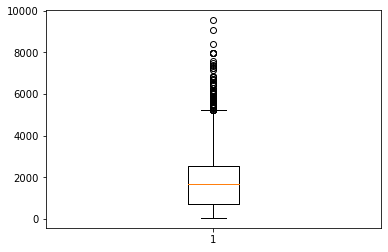

In [69]:
plt.boxplot(data_train[data_train['price_sqft']<1e4]['price_sqft'])
plt.show()


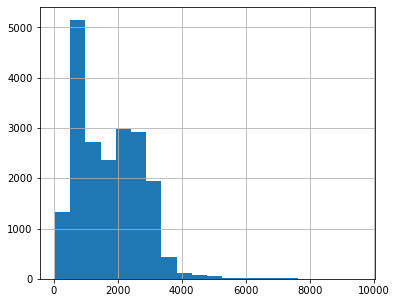

In [65]:
data_train[data_train['price_sqft']<1e4]['price_sqft'].hist(bins=20, figsize=(6,5))
plt.show()


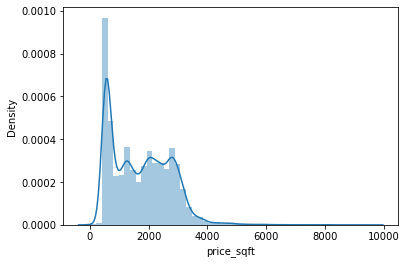

In [68]:
sns.distplot(data_train[data_train['price_sqft']<1e4]['price_sqft'])
plt.show()


In [71]:
price_extre_list = []
for uni_name in uni_property_name:
    price_describe = data_train[data_train['property_name']==uni_name]['price_sqft']
    mid_dt = price_describe.describe()['50%']
    min_dt = price_describe.describe()['min']
    max_dt = price_describe.describe()['max']
    if min_dt < mid_dt / 10:
        price_extre_list += data_train[(data_train['price_sqft'] < mid_dt/10) & (data_train['property_name'] == uni_name)]['listing_id'].values.tolist()

    if max_dt > mid_dt * 10:
        price_extre_list += data_train[(data_train['price_sqft'] > mid_dt*10) & (data_train['property_name'] == uni_name)]['listing_id'].values.tolist()


In [72]:
price_extre_list

[122873,
 859370,
 974261,
 891247,
 894004,
 481515,
 147171,
 272568,
 842529,
 424962,
 955844,
 658359,
 137240,
 466852,
 385586,
 287109]

In [73]:
data_train.loc[data_train['listing_id'].isin(price_extre_list)]


,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price,price_sqft
663,122873,3 bed condo for sale in midtown modern,18 tan quee lan street,midtown modern,condo,99-year leasehold,2024.0,3.0,2.0,1066.0,...,"studio, 1, 2, 3, 4, 5, 6 br",558.0,https://www.99.co/singapore/condos-apartments/...,1.298416,103.857178,0,bugis,downtown core,3.088050e+07,2.896857e+04
2609,466852,hdb flat for sale in 423 tampines street 41,pasir ris / tampines (d18),sun plaza gardens,Hdb 4 Rooms,99-year leasehold,1985.0,3.0,2.0,9727.0,...,"2, 3 br",NaN,https://www.99.co/singapore/hdb/sun-plaza-gard...,1.357079,103.947599,0,tampines east,tampines,5.355000e+05,5.505295e+01
4166,481515,hdb flat for sale in 78 lorong limau,balestier / toa payoh (d12),whampoa dew,hdb 4 rooms,99-year leasehold,2018.0,3.0,2.0,10774.0,...,3 br,405.0,https://www.99.co/singapore/hdb/whampoa-dew-de...,1.324910,103.855593,0,balestier,novena,8.484000e+05,7.874513e+01
5823,137240,hdb flat for sale in 637c punggol drive,hougang / punggol / sengkang (d19),the meadows,hdb 5 rooms,99-year leasehold,2005.0,3.0,2.0,12847.0,...,"1, 3, 4, 5 br",NaN,https://www.99.co/singapore/hdb/the-meadows-de...,1.399309,103.915099,0,waterway east,punggol,6.405000e+05,4.985600e+01
5976,385586,hdb flat for sale in 238 compassvale walk,hougang / punggol / sengkang (d19),compassvale plains,hdb 4 rooms,99-year leasehold,1999.0,1.0,10.0,232.0,...,"1, 3, 4 br",NaN,https://www.99.co/singapore/hdb/compassvale-pl...,1.390556,103.898921,0,sengkang town centre,sengkang,3.924243e+10,1.691484e+08
6168,955844,hdb flat for sale in 95 old airport road,eunos / geylang / paya lebar (d14),kallang airport,hdb,99-year leasehold,1969.0,2.0,1.0,6479.0,...,"2, 3, 4, 5 br",NaN,https://www.99.co/singapore/hdb/kallang-airpor...,1.308416,103.887394,0,aljunied,geylang,3.570000e+05,5.510110e+01
8285,859370,hdb flat for sale in 341 bukit batok street 34,bukit batok / bukit panjang / choa chu kang (d23),hdb-bukit batok,hdb,99-year leasehold,1986.0,2.0,2.0,8449.0,...,"studio, 1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/hdbbukit-batok...,1.362773,103.749183,0,hong kah north,bukit batok,4.042000e+05,4.783998e+01
9855,974261,hdb flat for sale in 319 bukit batok street 33,bukit batok / bukit panjang / choa chu kang (d23),hdb-bukit batok,Hdb 5 Rooms,99-year leasehold,1986.0,3.0,2.0,122.0,...,"studio, 1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/hdbbukit-batok...,1.361270,103.746427,0,hong kah north,bukit batok,6.489000e+05,5.318852e+03
11732,894004,hdb flat for sale in 51 teban gardens road,boon lay / jurong / tuas (d22),hdb-jurong east,Hdb 4 Rooms,99-year leasehold,1986.0,4.0,3.0,146.0,...,"studio, 1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/hdbjurong-east...,1.320759,103.736957,0,teban gardens,jurong east,7.854000e+05,5.379452e+03
14322,147171,hdb flat for sale in 149 silat avenue,alexandra / commonwealth (d3),hdb-bukit merah,hdb 3 rooms,99-year leasehold,1982.0,2.0,2.0,7760.0,...,"studio, 1, 2, 3, 4, 5 br",NaN,https://www.99.co/singapore/hdb/hdbbukit-merah...,1.277381,103.831857,0,kampong tiong bahru,bukit merah,4.410000e+05,5.682990e+01


* drop these records?